# Independence Tests Power over Increasing Dimension

In [3]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from power import power
from hyppo.independence import CCA, MGC, RV, Dcorr, Hsic, HHG
from hyppo.tools import *

sys.path.append(os.path.realpath('..'))

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics.pairwise import euclidean_distances
from abc import ABC, abstractmethod

# from hyppo.random_forest.base import RandomForestTest
from hyppo.independence._utils import sim_matrix
from hyppo.tools import perm_test


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}

def euclidean(x):
    return euclidean_distances(x)

class RandomForestTest(ABC):
    r"""
    A base class for an random-forest based independence test.
    """

    def __init__(self):
        # set statistic and p-value
        self.stat = None
        self.pvalue = None

        super().__init__()

    @abstractmethod
    def _statistic(self, x, y):
        r"""
        Calulates the random-forest test statistic.
        Parameters
        ----------
        x, y : ndarray
            Input data matrices.
        """


class KMERF(RandomForestTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="regressor", n_estimators=500, **kwargs):
        self.first_time = True
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be one of the following ")
        RandomForestTest.__init__(self)

    def _statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        if self.first_time:
            y = y.reshape(-1)
            self.clf.fit(x, y)
            self.first_time = False
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        y = y.reshape(-1, 1)
        disty = euclidean(y)
        stat = Dcorr(compute_distance=None)._statistic(distx, disty)
        self.stat = stat

        return stat

In [5]:
POWER_REPS = 5

SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

TESTS = [
#     KMERF,
    MGC,
    Dcorr,
    Hsic,
    HHG,
    CCA,
    RV,
]

In [6]:
def find_dim(sim):
    if sim not in SIMULATIONS.keys():
        raise ValueError("Invalid simulation")
        
    if sim in ["joint_normal", "sin_four_pi", "sin_sixteen_pi", "multiplicative_noise"]:
        dim = 10
    elif sim in ["multimodal_independence", "uncorrelated_bernoulli", "logarithmic"]:
        dim = 100
    elif sim in ["linear", "exponential", "cubic"]:
        dim = 1000
    elif sim in ["square", "diamond"]:
        dim = 40
    else:
        dim = 20
        
    return dim

def find_dim_range(dim):
    if dim < 20:
        lim = 10
    else:
        lim = 20
    
    dim_range = list(range(int(dim/lim), dim+1, int(dim/lim)))
    if int(dim/lim) != 1:
        dim_range.insert(0, 1)
    return dim_range

In [7]:
def estimate_power(sim, test):
    dim_range = find_dim_range(find_dim(sim))
    est_power = np.array([np.mean([power(test, sim, p=dim) for _ in range(POWER_REPS)])
                          for dim in dim_range])
    np.savetxt('../rf/vs_dimension/{}_{}.csv'.format(sim, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [9]:
# outputs = Parallel(n_jobs=-1, verbose=100)(
#     [delayed(estimate_power)(sim, test) for sim in SIMULATIONS.keys() for test in TESTS]
# )

In [16]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [17]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
    plt.suptitle("Multivariate Independence Testing", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS:
                test_name = test.__name__
                power = np.genfromtxt('../kmerf/vs_dimension/{}_{}.csv'.format(sim, test_name), delimiter=',')
                hsic_power = np.genfromtxt('../kmerf/vs_dimension/{}_Hsic.csv'.format(sim), delimiter=',')
                dim_range = find_dim_range(find_dim(sim))
                
                kwargs = {
                    "label": test.__name__,
                    "lw": 2,
                }
                if test_name in ["MGC", "KMERF"]:
                    kwargs["color"] = "#e41a1c"
                    kwargs["lw"] = 4
                    if test_name == "KMERF":
                        kwargs["linestyle"] = "dashed"
                
                if count in [0, 1, 2, 19]:
                    col.plot(dim_range, power - hsic_power, **kwargs)
                elif count in [8, 9]:
                    col.plot(dim_range[1:], (power - hsic_power)[1:], **kwargs)
                else:
                    col.plot(dim_range[2:], (power - hsic_power)[2:], **kwargs)
                col.set_xticks([3, dim_range[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.07, 'Dimensions', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power Relative to Hsic', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure, ncol=len(TESTS),
                     loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../kmerf/figs/indep_power_dimension.pdf', transparent=True, bbox_inches='tight')

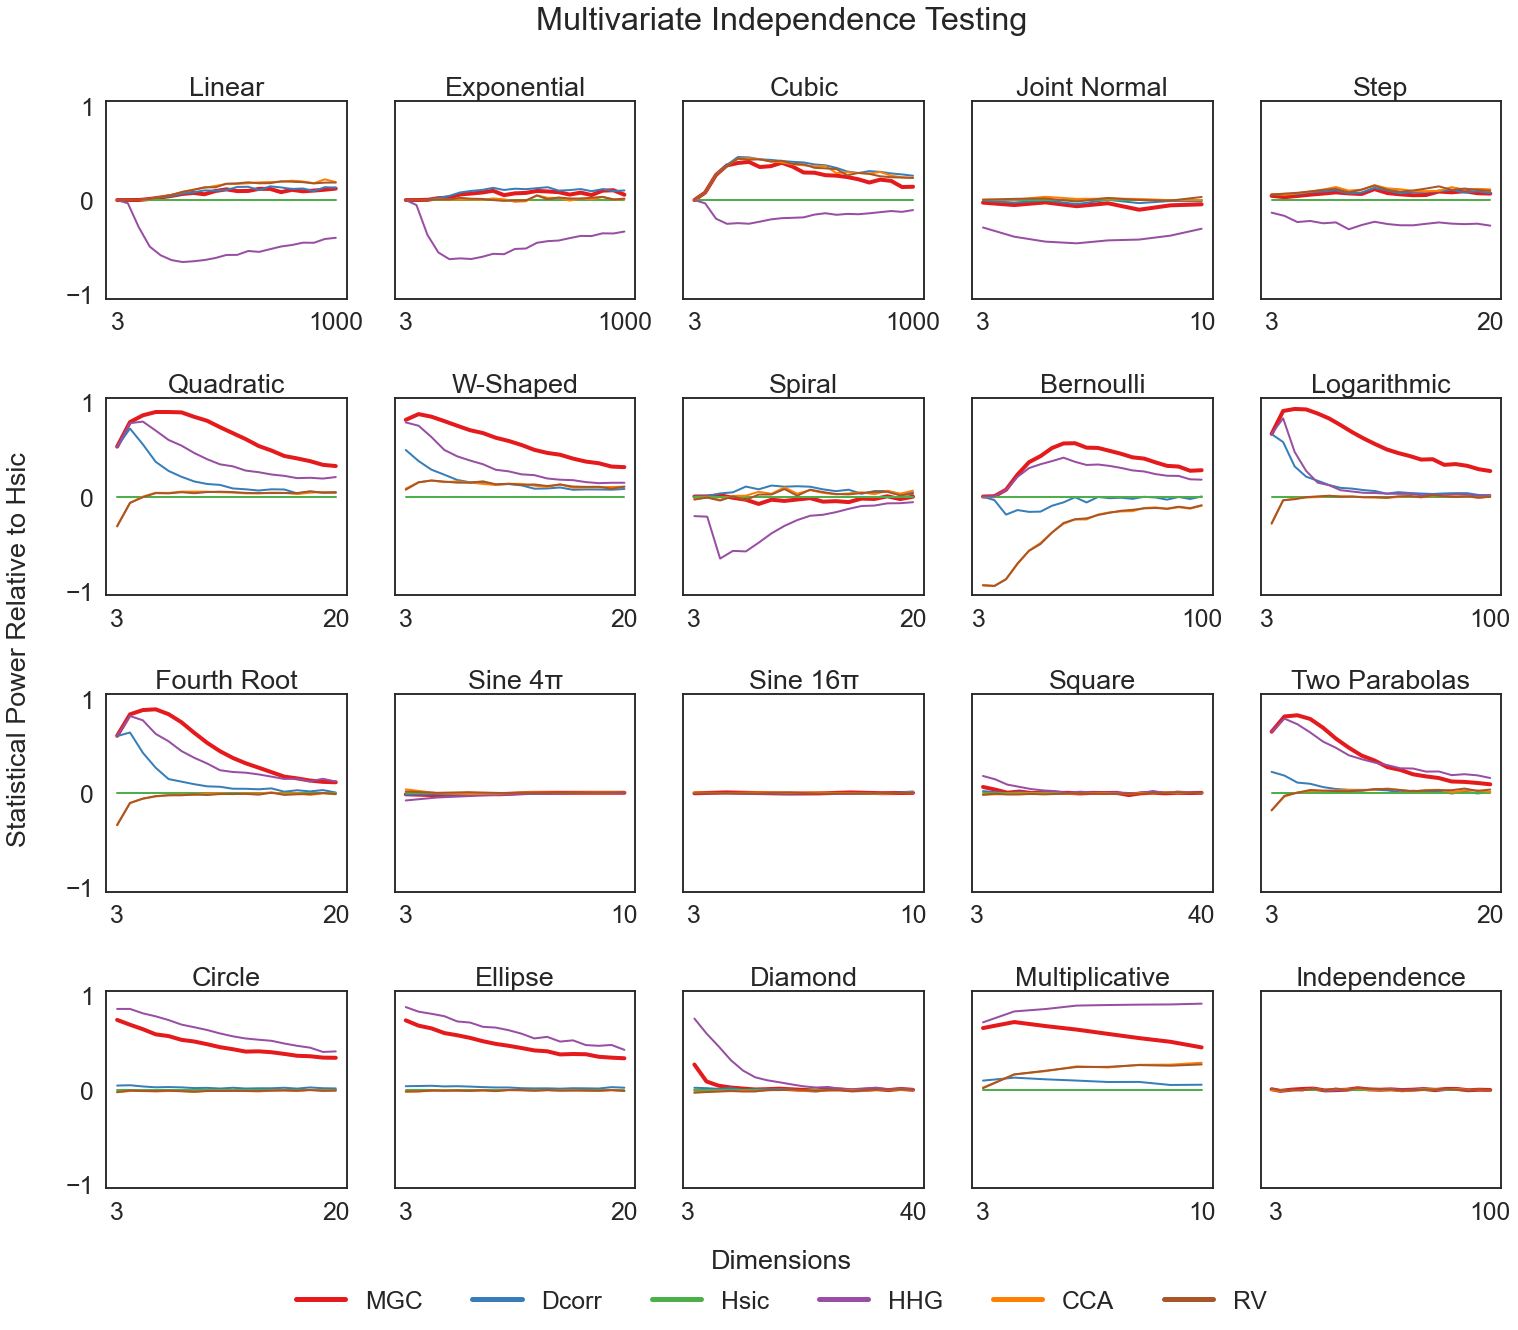

In [18]:
plot_power()